# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [37]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
r = np.array([0.8, 0.2])
entropy = -np.sum(r * np.log(r))
print(f"entropy = {round(entropy, 2)}")

entropy = 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [38]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
r = np.array([0.8, 0.2])
Lr = np.array([1,0])
Rr = np.array([0,1])

print(f"entropy = {round((sum(r * (1-r))) - 0.8 * np.sum(Lr * (1-Lr)) - 0.2 * np.sum(Rr * (1-Rr)), 2)}")

entropy = 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
n = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]


y = 1/len(n) * np.sum(n)
print(f"Предсказания равны  {y}")

Предсказания равны  40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [49]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-

    if feature_type == "real": # если тип признака число
    
        sort_ind = np.argsort(feature_vector) # индексы отсортированного списка значений
        sorted_values = feature_vector[sort_ind] # сортировка отсортированного списка значений по индексам
        # рассчет всех возможных порогов (среднее арифметическое соседей
        # исключается первый элемент и последний
        thresholds = (np.array(sorted_values[1:]) + np.array(sorted_values[0:-1])) * 0.5 

        if task == "classification": # если задача классификации
# решение через цикл            
#             h = []
#             target_vector = target_vector[sort_ind] # сортируем вектор прогнозов
#             for t in np.unique(thresholds)[1:]: # проходимся по всем уникальным порогам (без первого, т к смысл его брать)
#                 target_vector_l = target_vector[sorted_values < t].astype(bool) # левая вершина
#                 target_vector_r = target_vector[sorted_values >= t].astype(bool) # правая вершина
#                 p_l_1 = sum(target_vector_l) / len(target_vector_l) # вероятности класса 1 в левой
#                 p_l_0 = 1 - p_l_1 # вероятности класса 1 в левой
                
#                 p_r_1 = sum(target_vector_r) / len(target_vector_r) # вероятности класса 1 в правой
#                 p_r_0 = 1 - p_r_1 # вероятности класса 0 в правой
                
#                 h_children = (p_l_1*p_l_0*2 * len(target_vector_l) + p_r_1*p_r_0*2* len(target_vector_r)) / len(target_vector) #джини для дочерних
#                 h.append(h_children) # добавляем в список
            
              # родительская джини
#             prob_par_1 = np.sum(target_vector.astype(bool)) / len(target_vector)
#             prob_par_0 = 1 - prob_par_1
#             gini_par = 2 * prob_par_0 * prob_par_1
            
              # коэф информативности
#             ginis = gini_par - np.array(h)
            
            
#             best_ind = np.argmax(ginis) # максимиизация КИ - берем индекс
#             threshold_best = thresholds[best_ind] # лучший порог по индексу
#             best_ginis = ginis[best_ind] # лучший КИ по индексу
            
#             return(np.unique(thresholds)[1:], ginis, threshold_best, best_ginis)
        
            p1_R0 = np.sum(target_vector[sort_ind].astype(bool)) / len(target_vector) # вероятность класса 1 в род. вершине
            p2_R0 = 1 - p1_R0 # вероятность класса 0 в род. вершине
            H_R = 2 * p1_R0 * p2_R0 # энтропияи род. вершины
            
            
            # все возможные классы при всех порогах, которые идут в левую вершину (True - 1, False - 0)
            target_vector_sorted_l = target_vector[sort_ind].astype(bool)[:-1]
            # все возможные классы при всех порогах, которые идут в правую вершину (True - 1, False - 0)
            # обратный порядок вектора, так как так будет удобнее считать
            target_vector_sorted_r = target_vector[sort_ind].astype(bool)[-1:0:-1]
            

            left_lens = np.array((range(1, len(target_vector)))) # кол-во элементов в левой вершине

            p_l_1 = np.array(np.cumsum(target_vector_sorted_l) / left_lens) # вероятности класса 1 в леввой вершине
            p_l_0 = np.array(1 - p_l_1) # вероятности класса 0 в леввой вершине
            p_r_1 = np.array((np.cumsum(target_vector_sorted_r) / left_lens)[::-1]) # вероятности класса 1 в правой вершине
            p_r_0 = np.array(1 - p_r_1) # вероятности класса 0 в правой вершине

            # суммарная энтропия для дочерних вершин
            ginis_child = (2 * p_l_1 * p_l_0 * left_lens + 2 * p_r_1 * p_r_0 * left_lens[::-1]) / len(target_vector)
            
            # критерий информативности (род. энтропия - суммарная дочерняя)
            ginis = H_R - ginis_child
            
            threshold_best = thresholds[np.argmax(ginis)] # максимизируем критерий информативности, берем его индекс
                                                          # и выводим порог под данным индексом
            gini_best = ginis[np.argmax(ginis)] # максимизируем критерий информативности, берем его индекс
                                                # и выводим макс критерия информативности

            return(thresholds, ginis, threshold_best, gini_best)

    
        if task == "regression": # если задача регрессии
            
# # решение через цикл
#             variance = []
#             target_vector = target_vector[sort_ind]
#             for t in np.unique(thresholds)[1:]: # перебор ввссех уникальных пророгов кроме первого (нет смысла его брать)
#                 target_vector_l = target_vector[sorted_values < t] # все объекты влево
#                 target_vector_r = target_vector[sorted_values >= t] # остальные объекты вправво
#                 mean_l = np.sum(target_vector_l) / len(target_vector_l) # среднее левой
#                 var_l =  np.sum(np.square(target_vector_l - mean_l)) / len(target_vector_l) # дисперсия леввой
#                 mean_r = np.sum(target_vector_r) / len(target_vector_r) # среднее правой
#                 var_r =  np.sum(np.square(target_vector_r - mean_r)) / len(target_vector_r) # дисперсия правой
#                 var_tot = (var_l * len(target_vector_l) + var_r * len(target_vector_r))/len(target_vector) # суммарная дисперсия
#                 variance.append(var_tot)
            
#             # родительская дисперсия
#             var_R = np.sum(np.square(target_vector - np.mean(target_vector))) / len(target_vector)
#             variance =  np.array(variance)
#             variances = var_R - variance
            
#             best_ind = np.argmax(variances) # максимиизация КИ - берем индекс
#             threshold_best = np.unique(thresholds)[1:][best_ind] # лучший порог по индексу
#             best_variance = variances[best_ind] # лучший КИ по индексу
            
#             return(np.unique(thresholds)[1:], variances, threshold_best, best_variance)


# решение через векторы: считает чуть дольше чем с циклом ) - 5 секунд, но было вообще где-то минута...  
# Так как тут возникает проблема с поввторяющимися значениями признака, между котрыми нельзя ставить порог
            target_vector = target_vector[sort_ind] # сортировка вектора с прогнозами

            unique_ind_t = np.unique(thresholds, return_index=True) # уникальные пороги + индексы униикальных значений 
                                                                    # => между этиими индексами будут ПОВТОРЯЮЩИЕСЯ элементы =>
                                                                    # он должны быть гарантировано в одной вершине =>
                                                                    # порогом может быть только уникальное значение – все значения меньше него – влево, остальные – вправо
            
            # нужно понять, при каких прогнозах признаки одинаковые. Для этого будем делать срезы:
            # начало срезов для левой вершины (все возможные варианты) – от 0 до n, причем n не может быть между одинаковыми элементами
            start_l, end_l = np.zeros(len(unique_ind_t[1][1:]), dtype = int), np.array(unique_ind_t[1][1:] + 1, dtype = int)
            
            # начало срезов для правой вершины (все возможные варианты) – все остальные элементы, которые не вошли в правую вершину до конца
            start_r, end_r = np.array(unique_ind_t[1][1:] + 1, dtype = int), np.ones(len(unique_ind_t[1][-1::-1]), dtype = int) * -1

            # масссивы из массивов со всеми возможными вариантами прогнозв в вершинах
            l = np.array(list(map(lambda range: target_vector[range[0]:range[1]], zip(start_l,end_l))), dtype=object)  
            r = np.array(list(map(lambda range: target_vector[range[0]:range[1]], zip(start_r,end_r))), dtype=object)
            
            square_dif = map(np.square, l - np.array(list(map(np.mean, l))))  # квадраты разностей
            var_l = np.array(list(map(np.mean, square_dif))) # дисперсяи левой вершины
            
            square_dif_r = (map(np.square, r - np.array(list(map(np.mean, r)))))  # квадраты разностей
            var_r = np.array(list(map(np.mean, square_dif_r))) # дисперсия правой вершины

            var_total = (var_l * np.array(list(map(len, l))) + var_r * np.array(list(map(len, r)))) / len(target_vector) # дисперсия дочерних вершин

            # variance parent
            mean = np.sum(target_vector) / len(target_vector)
            var_par = np.sum(np.square(target_vector - mean)) / len(target_vector)    
            
            variance = var_par - var_total # критерии информативностии
            best_ind = np.argmax(variance) # макисмиизация КИ - берем индекс 
            thresholds = unique_ind_t[0][1:]
            threshold_best = thresholds[best_ind] # лучший порог по индексу
            best_variance = variance[best_ind] # лучший КИ по индексу

            return(thresholds, variance, threshold_best, best_variance)

    elif feature_type == "categorical":
    
        thresholds = np.array(np.unique(feature_vector), dtype='object') # все возможные пороги (уникальные значения признаков)
        # создаем матрицу размера 'кол-во порогов' на "кол-во признаков"
        matrix_classes = thresholds.reshape(-1, 1) * np.ones([len(thresholds), len(feature_vector)], dtype=int)
        # создаем матрицу прогнозов размера 'кол-во порогов' на "кол-во признаков"
        matrix_target = np.ones([len(thresholds), len(feature_vector)], dtype=int) * target_vector
        # матрица с булевыми значениями (True - класс 1, False - класс 0)
        bool_class = matrix_classes == feature_vector

        if task == "classification":
            
#  Решение через цикл             
#             ginis = []
#             for t in thresholds:
#                 l = target_vector[feature_vector == t] # все влево 
#                 r = len(target_vector) - l # длина правой вершины 
#                 p_l_1 = np.sum(l.astype(bool)) / len(l)  # вер класса 1 в левой 
#                 p_l_0 = 1 - p_l_1 # вер класса 0 в левой 

#                 p_r_1 = np.sum(r.astype(bool)) / len(r) # вер класса 1 в правой 
#                 p_r_0 = 1 - p_r_1 # вер класса 0 в правой 
#                 gini_child = ( 2 * p_l_0 * p_l_1 * len(l) + 2 * p_r_1 * p_r_0 * len(r) ) / len(target_vector) # дочерний джини

#                 # родтельский джини
#                 prob_par_1 = np.sum(target_vector.astype(bool)) / len(target_vector)
#                 prob_par_0 = 1 - prob_par_1
#                 gini_par = 2* prob_par_0 * prob_par_1

#                 # критерий информативности
#                 gini = gini_par - gini_child
#                 ginis.append(gini)

#             best_ind = np.argmax(ginis)
#             best_gini = ginis[best_ind]
#             threshold_best = thresholds[best_ind]



#  Решение через векторы  
            if len(thresholds) > 1: # если признак не константный
            # нужно как-то из матрицы с прогнозами достать только те, признаки при которых равны определеннму значению 
            # в матрице matrix_classes значение равно True, значит достаем прогноз из матрицы 
            # но нужно еще и разделить данные прогнозы по признакам (при каком знач признака поллучаются такие прогнозы)
            # так как вот такая запись "targets_1 = matrix_target[bool_class]" дает просто все прогнозы БЕЗ разбиения на значения признаков
            # просто массив [0,1,1,0] 
        
                # суммируем кол-во признаков, которые равны определенному значению – это будет основа для индексации по нижней границе
                lst = list(np.cumsum(np.sum(bool_class, axis = 1)))[::-1]  # делаем инверсию, чтобы добавить ноль, 
                                                                           # а потом, чтобы он оказался не в конце, а в начале
                lst.append(0) # добавляем ноль – так  как индексация начинается с нуля
                lst = lst[::-1] # возвращаем исходный порядок начальных индексов

                start = np.array(lst[:-1]) # начало для получения среза тех прогнозов, объекты которых  принадлежат к 1 классу 
                end = np.cumsum(np.sum(bool_class, axis =1)) # конец среза 
                
                # получаем два массива (их длина равна кол-ву возможных порогов): 
                # например, array([0, 1, 3, 5]) и array([1, 3, 5, 6])
                # значит если порог – значение первого признака, то нужные нам прогнозы лежат в срезе [0,1]
                # если порог – значение первого признака, то нужные нам прогнозы лежат в срезе [1,3] и т д

                targets_1 = matrix_target[bool_class] # все нужные прогнозы, но БЕЗ РАЗБИЕНИЯ НА ПОРОГИ
                
                # список из векторов, где каждый вектор содержит прогнозы, соответствующие возможным порогам
                l = list(map(lambda range: targets_1[range[0]:range[1]], zip(start,end))) 


                l_sum = np.array(list(map(sum, l))) # сумма прогнозов при каждом пороге в левой вершине
                r_sum = sum(target_vector) - l_sum # сумма прогнозов при каждом пороге в правой вершине

                len_l = np.array(list(map(len, l))) # длина левой вершины
                len_r = len(target_vector) - len_l # длина правой вершины

                p_l_1 = l_sum / len_l # вероятность в левой класса 1
                p_l_0 = 1 - p_l_1 # вероятность в левой класса 0
                Hl = p_l_1 * p_l_0 # перемножение 

                p_r_1 = r_sum / len_r # аналогично для правой
                p_r_0 = 1 - p_r_1
                Hr = p_r_1 * p_r_0

                ginis_child = (2* Hl * len_l + 2* Hr  * len_r) / len(target_vector) # джини дочерних вершин (вектор)

                # джини родительской
                prob_par_1 = np.sum(target_vector.astype(bool)) / len(target_vector) 
                prob_par_0 = 1 - prob_par_1
                gini_par = 2 * prob_par_0 * prob_par_1

                # критерий информативности
                ginis = gini_par - ginis_child
                best_ind = np.argmax(ginis) # максимизация
                best_gini = ginis[best_ind] # лучший джини
                threshold_best = thresholds[best_ind] # лучший порог

                return(thresholds, ginis, threshold_best, best_gini)
            
            else: # если признак константный (пусть возварает нули)
                return(thresholds, np.array(0), thresholds, np.array(0))
        
        if task == "regression": # логика аналогична задаче классификации (записана только векторная форма)
            
            # левая дочерняя вершина
            lst = list(np.cumsum(np.sum(bool_class, axis =1)))[::-1]
            lst.append(0)
            lst = lst[::-1]

            start_1 = np.array(lst[:-1]) # вектор начала индексации
            end_1 = np.cumsum(np.sum(bool_class, axis =1)) # векттор конца индексации (по срезам)

            targets_1 = matrix_target[bool_class] # вектор с прогнозами БЕЗ расспределения по признакам

            l = list(map(lambda range: targets_1[range[0]:range[1]], zip(start_1,end_1))) # для каждого приизнака отдельный вектор
            
            mean_l = np.array(np.array(list(map(sum, l))) / np.array(list(map(len, l)))) # средние значения
            square_dif = list(map(np.square, np.array(l, dtype='object') - mean_l))  # квадраты разностей
            sum_square_dif = np.array(list(map(np.sum, square_dif))) # сумма квадраты разностей
            var_l = np.array(sum_square_dif /  np.array(list(map(len, l)))) # дисперсяи левой вершины
            
            
            # правая дочерняя вершина (аналогичная логика)
            lst = list(np.cumsum(np.sum(~bool_class, axis =1)))[::-1]
            lst.append(0)
            lst = lst[::-1]

            start_0 = np.array(lst[:-1])
            end_0 = np.cumsum(np.sum(~bool_class, axis =1))

            targets_0 = matrix_target[~bool_class] #  здеесь нужен ОБРАТНЫЙ массив, где true - принадлежность не к классу n

            r = list(map(lambda range: targets_0[range[0]:range[1]], zip(start_0,end_0)))
            
            mean_r = np.array(np.array(list(map(sum, r))) / np.array(list(map(len, r))))
            square_dif_r = list(map(np.square, np.array(r, dtype='object') - mean_r))  # квадраты разностей
            sum_square_dif_r = np.array(list(map(np.sum, square_dif_r))) # сумма квадраты разностей
            var_r = np.array(sum_square_dif_r /  np.array(list(map(len, r)))) # дисперсяи правой вершины

            var_total = (var_l * np.array(list(map(len, l))) + var_r * np.array(list(map(len, r)))) / len(target_vector) # дисперсия дочерних вершин
            
            # variance parent
            mean = np.sum(target_vector) / len(target_vector)
            var_par = np.sum(np.square(target_vector - mean)) / len(target_vector)
            
            # критерий информативности
            variance = var_par - var_total
            best_ind = np.argmax(variance) # максимизация
            best_variance = variance[best_ind] # лучшая дисперсия
            threshold_best = thresholds[best_ind] # лучший порог

            
            
            return(thresholds, variance, threshold_best, best_variance)

Эту функцию можно протестировать на датасете `California`.

In [7]:
from sklearn.datasets import fetch_california_housing

In [50]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [41]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [51]:
lst = find_best_split(np.array(X['MedInc']), y, task = 'regression')
lst

(array([ 0.51795,  0.536  ,  0.54275, ..., 15.     , 15.00005, 15.0001 ]),
 array([0.0005251 , 0.0004921 , 0.00060184, ..., 0.01914413, 0.01872666,
        0.01830925]),
 5.03515,
 0.4128905326919937)

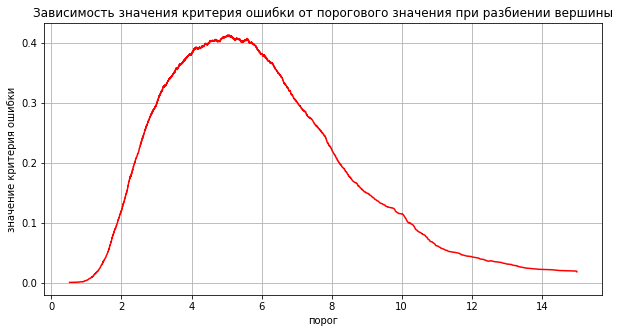

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(lst[0], lst[1], color = "r")
plt.grid()
plt.xlabel("порог")
plt.ylabel("значение критерия ошибки")
plt.title("Зависимость значения критерия ошибки от порогового значения при разбиении вершины")
plt.show()

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [53]:
print(f"The best predicate:[x < {lst[2]}]") 

The best predicate:[x < 5.03515]


так как при нем критерий информативности (как разница между родительской и дочерними дисперсиями) максимален

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [54]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
        if node["type"] == "terminal":
            return node["class"]

        index = node["feature_split"]
        fet_x = x[index]


        
        if self._feature_types[index]  == "real":
            is_left = (fet_x < node["threshold"])
        elif self._feature_types[index]  == "categorical":
            is_left = (fet_x == node["category_split"])
            
        if is_left == True:
            return self._predict_node(x, node["left_child"])
        else:
            return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

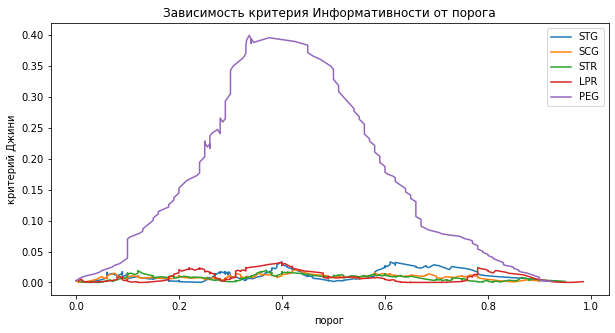

In [55]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
data = pd.read_csv("students.csv")

plt.figure(figsize=(10, 5))

plt.title("Зависимость критерия Информативности от порога")
plt.xlabel('порог')
plt.ylabel('критерий Джини')

plt.plot(find_best_split(data['STG'],data['UNS'])[0], find_best_split(data['STG'],data['UNS'])[1])
plt.plot(find_best_split(data['SCG'],data['UNS'])[0], find_best_split(data['SCG'],data['UNS'])[1])
plt.plot(find_best_split(data['STR'],data['UNS'])[0], find_best_split(data['STR'],data['UNS'])[1])
plt.plot(find_best_split(data['LPR'],data['UNS'])[0], find_best_split(data['LPR'],data['UNS'])[1])
plt.plot(find_best_split(data['PEG'],data['UNS'])[0], find_best_split(data['PEG'],data['UNS'])[1])

plt.legend(['STG', 'SCG', 'STR', 'LPR', 'PEG'])
plt.show()

Text(0, 0.5, 'класс')

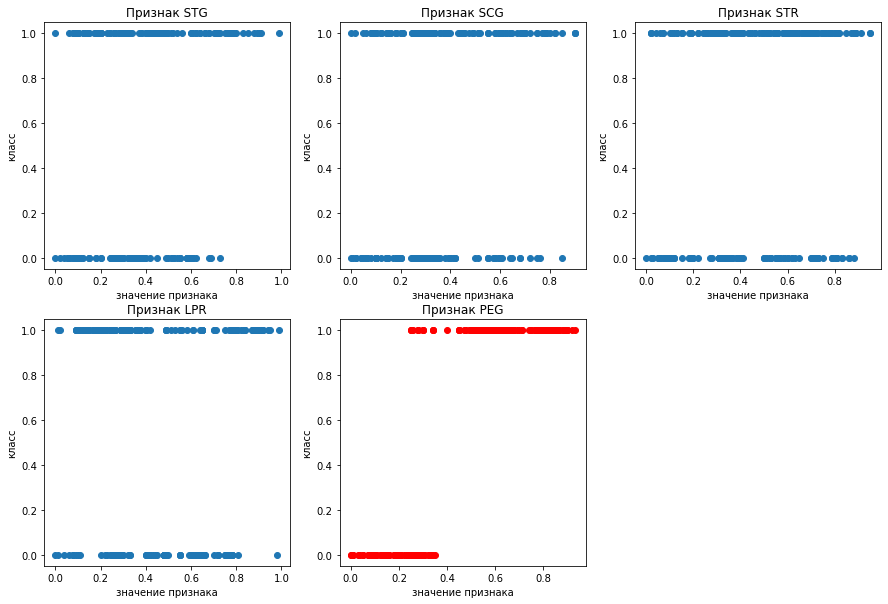

In [56]:
plt.figure(figsize=(15, 10))


plt.subplot(2,3,1)
plt.scatter(data['STG'], data['UNS'])
plt.title('Признак STG')
plt.xlabel('значение признака')
plt.ylabel('класс')

plt.subplot(2,3,2)
plt.scatter(data['SCG'], data['UNS'])
plt.title('Признак SCG')
plt.xlabel('значение признака')
plt.ylabel('класс')

plt.subplot(2,3,3)
plt.scatter(data['STR'], data['UNS'])
plt.title('Признак STR')
plt.xlabel('значение признака')
plt.ylabel('класс')

plt.subplot(2,3,4)
plt.scatter(data['LPR'], data['UNS'])
plt.title('Признак LPR')
plt.xlabel('значение признака')
plt.ylabel('класс')


plt.subplot(2,3,5)
plt.scatter(data['PEG'], data['UNS'], c= 'r')
plt.title('Признак PEG')
plt.xlabel('значение признака')
plt.ylabel('класс')

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

ОТВЕТ: 

- нужно производить деление выборки по признаку PEG, так как на линейном граифике определился такой порог, при котором критерий Джини минимален (разница между 
- Результат согласуется с диаграммой рассеяния, так как именно для признака PEG диаграмма показывает наилучший способ разбиения выборки на два класса (область пересечения классов минимальна по сравнению с другими признаками)

- Кривая для хороших признаков – это та кривая, на которой явно видно, при каком пороге разница между энтропиями в родительской и дочерних вершинах максимальна
- На кривых для плохих приизнаков такого не видно – их колебания несильные, то есть при любом пороге  критерий информативности практически одиинаковый

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [57]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
from sklearn.model_selection import train_test_split
df = pd.read_csv('agaricus-lepiota.data')

from sklearn.preprocessing import LabelEncoder
df = df.apply(LabelEncoder().fit_transform)
df.head(5)

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [58]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'p'],
                                                   df['p'],
                                                   test_size=0.5,
                                                    random_state = 112345
                                                   )


dt = DecisionTree(feature_types = ['categorical']* X_train.shape[1])
dt.fit(np.array(X_train), np.array(y_train))
y_pred = dt.predict(np.array(X_test))

from sklearn.metrics import accuracy_score
print(f'accuracy = {accuracy_score(y_test, y_pred)}')

accuracy = 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [19]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [20]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

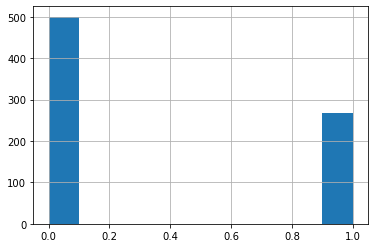

In [21]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [22]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]], 
                                                    data['Outcome'], 
                                                    test_size = 0.3, 
                                                   random_state=195)

XT_train, XV_train, yt_train, yv_train = train_test_split(X_train, 
                                                        y_train, 
                                                        test_size = 0.3,
                                                        random_state=238)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [23]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
import itertools
from sklearn.metrics import f1_score

depth = np.arange(1, 11) # генеруем возможную глубину (от 1 до 10)
elements = np.arange(2, 31) # генеруем возможное кол-во элементов (от 2 до 30)

combinations = itertools.product(depth, elements) # создаем все возможные комбинации из глубин и кол-ва элментов в листе
list_of_f1 = []
list_of_pairs = []
for max_depth, min_samples_leaf in combinations: # проходимся по каждой паре
    
    dt = DecisionTreeClassifier(max_depth=max_depth,  min_samples_leaf = min_samples_leaf) # создаем дерево
    dt.fit(XT_train, yt_train)
    list_of_f1.append(f1_score(yv_train, dt.predict(XV_train))) # добавляем в список метрику
    list_of_pairs.append([max_depth, min_samples_leaf]) # добавляем соответсвующую метрике пару глубины и кол-ва элментов в листе
    
best_ind = np.argmin(list_of_f1) # инекс мин значения метрики
print(list_of_pairs[best_ind])
print(list_of_f1[best_ind])

[3, 8]
0.4


In [24]:
dt = DecisionTreeClassifier(max_depth=list_of_pairs[best_ind][0],  min_samples_leaf = list_of_pairs[best_ind][1])
dt.fit(X_train, y_train)

print(f"accuracy = {accuracy_score(y_test, dt.predict(X_test))}")
print(f"roc_auc_score = {roc_auc_score(y_test, dt.predict(X_test))}")
print(f"precision_score = {precision_score(y_test, dt.predict(X_test))}")
print(f"recall_score = {recall_score(y_test, dt.predict(X_test))}")

accuracy = 0.7575757575757576
roc_auc_score = 0.7007290095525389
precision_score = 0.6833333333333333
recall_score = 0.5256410256410257


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [25]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
dt = DecisionTreeClassifier(max_depth=list_of_pairs[best_ind][0],  min_samples_leaf = list_of_pairs[best_ind][1])
Bdt = BaggingClassifier(dt, n_estimators=50)
Bdt.fit(X_train, y_train)

print(f"accuracy = {accuracy_score(y_test, Bdt.predict(X_test))}")
print(f"roc_auc_score = {roc_auc_score(y_test, Bdt.predict(X_test))}")
print(f"precision_score = {precision_score(y_test, Bdt.predict(X_test))}")
print(f"recall_score = {recall_score(y_test, Bdt.predict(X_test))}")

accuracy = 0.8051948051948052
roc_auc_score = 0.7398190045248867
precision_score = 0.8235294117647058
recall_score = 0.5384615384615384


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [26]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

# считает довольно долго :(, поэтому пришлось сильно сокращать кол-во возможных пар гиперпараметров

from sklearn import svm
from sklearn.model_selection import cross_val_score

depth = np.arange(3, 5)
elements = np.arange(2, 4)

combinations = itertools.product(depth, elements) # создаем пары возможных комбинаций

f1_c = []
patams_c = []

for max_depth, min_samples_leaf in combinations: # проходиимся по парам
    clf = svm.SVC(kernel='linear', C=1)
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='f1_macro') # считаем показатели
    f1_c.append(np.mean(scores)) #  усредняем их
    patams_c.append([max_depth, min_samples_leaf])
    
best_ind = np.argmin(f1_c)
print(f1_c[best_ind])
print(patams_c[best_ind])

0.7123169956587304
[3, 2]


In [27]:
rfclf = RandomForestClassifier(n_estimators=50, 
                               max_depth=patams_c[best_ind][0],  
                               min_samples_leaf = patams_c[best_ind][1])
rfclf.fit(X_train, y_train)

print(f"accuracy = {accuracy_score(y_test, rfclf.predict(X_test))}")
print(f"roc_auc_score = {roc_auc_score(y_test, rfclf.predict(X_test))}")
print(f"precision_score = {precision_score(y_test, rfclf.predict(X_test))}")
print(f"recall_score = {recall_score(y_test, rfclf.predict(X_test))}")

accuracy = 0.7878787878787878
roc_auc_score = 0.7173202614379085
precision_score = 0.7959183673469388
recall_score = 0.5


ОТВЕТ:
- Из трех моделей лучше всего себя показала композиция построенная с помощью Бэггинга на 50 деревьях

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [32]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
# тоже считает долго – можно уменьшить кол-во n_estimators, но графиик красивый
n_estimators = np.arange(1, 201)
sp = []
for i in n_estimators:
    rfclf = RandomForestClassifier(n_estimators=i)
    rfclf.fit(X_train, y_train)
    sp.append(roc_auc_score(y_test, rfclf.predict(X_test)))

Text(0.5, 0, 'n_estimators')

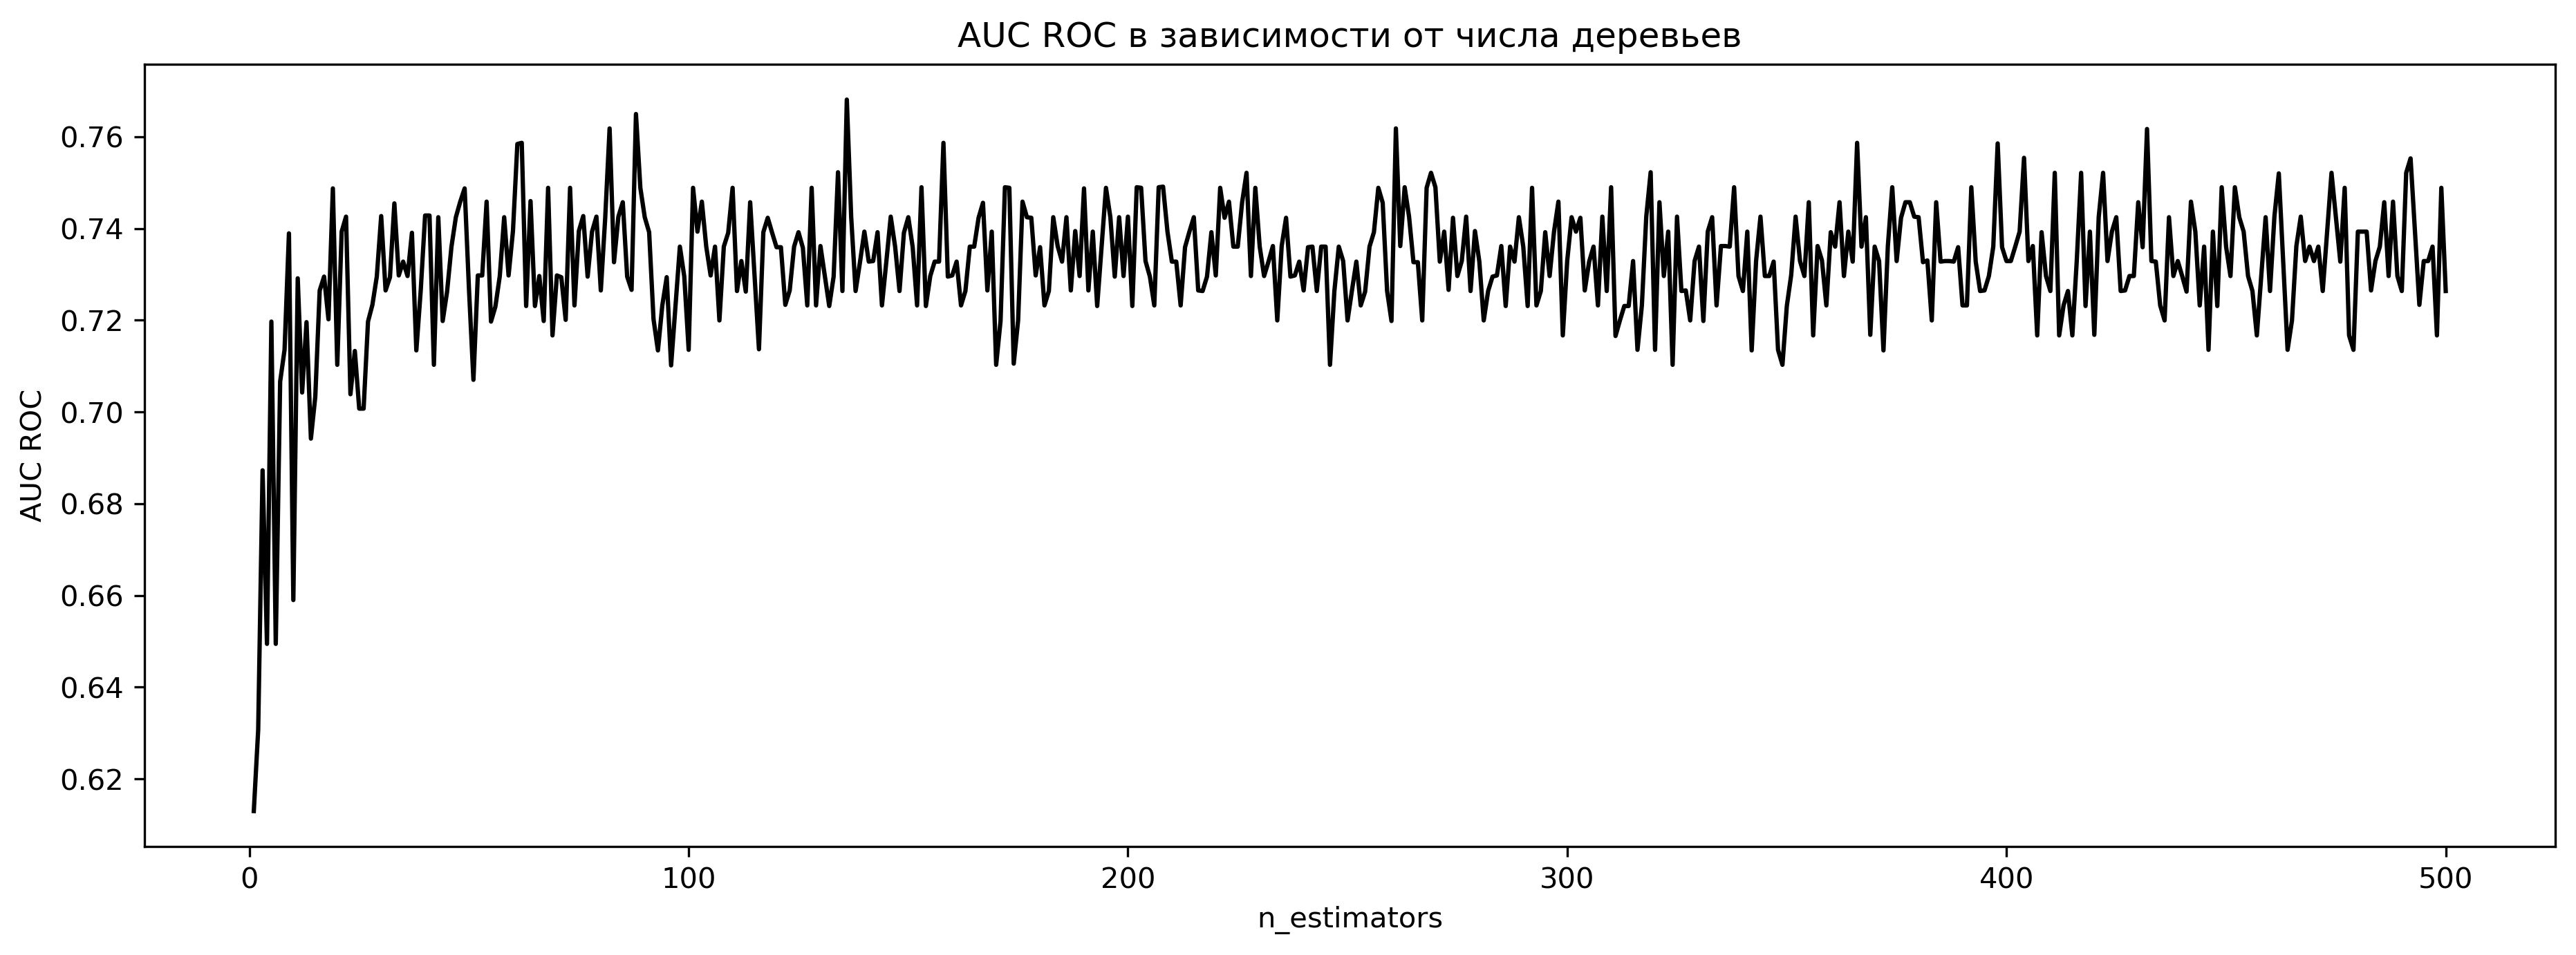

In [31]:
plt.figure(figsize=(15, 5), dpi = 300)
plt.plot(n_estimators, sp, color=[0.0, 0.0, 0.0])
plt.title("AUC ROC в зависимости от числа деревьев")
plt.ylabel("AUC ROC")
plt.xlabel("n_estimators")

ОТВЕТ: с увеличение числа деревьев колебания метрики все больше уменьшаются => случайный лес НЕ ПЕРЕОБУЧАЕТСЯ при росте кол-ва деревьев в композиции

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

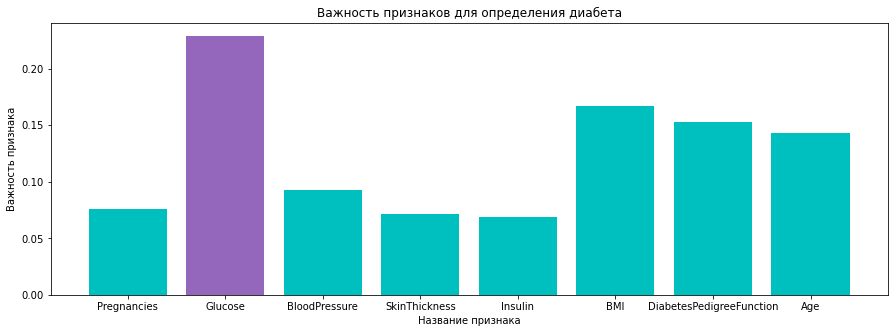

In [54]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
x = ['Pregnancies', 'Glucose', 'BloodPressure', 
   'SkinThickness', 'Insulin', 
   'BMI','DiabetesPedigreeFunction', 'Age' ]

plt.figure(figsize=(15, 5))
plt.bar(x, height = rfclf.feature_importances_, color = ["c", [0.58039, 0.40392, 0.74118], "c", "c", "c", "c", "c","c"])
plt.title("Важность признаков для определения диабета")
plt.xlabel('Название признака')
plt.ylabel('Важность признака')
plt.show()

ОТВЕТ: самый важный признак – уровень глюкозы